# Trivadis followers: What do they tweet about?

In [1]:
import pandas as pd
import numpy as np
import config
import sys
import re
from ast import literal_eval
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import wordcloud
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

pd.set_option('display.max_colwidth', 100)

In [2]:
target = config.target_user
target_month = config.target_month

In [3]:
source_dir = "{}/data/twitter/tweets/{}".format(config.dir_prefix, target)

tokenized_and_preprocessed_file = '/'.join([source_dir, target_month  + '_tokenized_and_preprocessed.csv'])
english_file = '/'.join([source_dir, target_month  + '_english.csv'])
french_file = '/'.join([source_dir, target_month  + '_french.csv'])
german_file = '/'.join([source_dir, target_month  + '_german.csv'])

## Tweets in English

In [4]:
tweets_english = pd.read_csv(english_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

def remove_hash(wordlist):
    return(list(map(lambda x: re.sub(r'^#','',x), wordlist)))

def remove_at(wordlist):
    return(list(map(lambda x: re.sub(r'^@','',x), wordlist)))
    
tweets_english['text_wo_#'] = tweets_english['text_processed'].apply(lambda x: remove_hash(x))
tweets_english['text_wo_#@'] = tweets_english['text_wo_#'].apply(lambda x: remove_at(x))

X_train_en = tweets_english['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("english"))
relevant_words = set(['not', 'nor', 'no', 'wasn', 'ain', 'aren', 'very', 'only', 'but', 'don', 'isn', 'weren'])

additional_stopwords = set(['us'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [5]:
X_train_en[-10:-1]

1370                                      pfierens oraclebase no issues for me up to now UpgradedWhenISeeIt
1371         oraesque I've never seen a production DB with the RI turned off that did not have damaged data
1372                                      UnitFact Why dimensional analysis matters https://t.co/P3vuB0rsoa
1373    UKOUG The last UKOUG Systems SIG of 2017 takes place this afternoon Some fantastic sessions on t...
1374    UKOUG Delegates are all ears at Albert Whites UKOUG Systems SIG sessions delving into how OpenSt...
1375                                          Nephentur why thanx Christian And u caught me on a good day 🙄
1376    philippe_lions A very powerful OracleDV new feature Dataflows easily organize wrangle and enrich...
1377                                            I hope it depends means think twice https://t.co/bPcMV4Lw5n
1378    thepunningman Death The end is nigh The 5 horsemen are here Pestilence Did he say 5 Famine He di...
Name: text_wo_#@, dtype: obj

In [6]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_en)
feature_names = vectorizer.get_feature_names()

In [7]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

In [8]:
def generate_word_cloud(model, topic_number, max_words, width, height):
    topic = model.components_[topic_number]
    frequencies = [(feature_names[i], topic[i]) for i in topic.argsort()]
    top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
    cloud = wordcloud.WordCloud(width=width, height=height, max_words=max_words, random_state=0).generate_from_frequencies(frequencies)
    return cloud
  
def show_word_clouds(model, subplots, num_words):    
    for i in range(model.n_topics):
        wordcloud = generate_word_cloud(model = model, topic_number = i, max_words = num_words,width = 800, height = 600)
        subplots[i].imshow(wordcloud)
        subplots[i].axis('off')

def print_top_words(model, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))
        print()
    


## Most dominating topics - overall

Topic #0:
175.4: oracle
109.1: cloud
102.5: new
72.8: data
72.0: 2016
66.6: iamcp
63.8: talend
63.4: check
62.7: thanks
54.7: database

['175.4: oracle', '109.1: cloud', '102.5: new', '72.8: data', '72.0: 2016', '66.6: iamcp', '63.8: talend', '63.4: check', '62.7: thanks', '54.7: database']


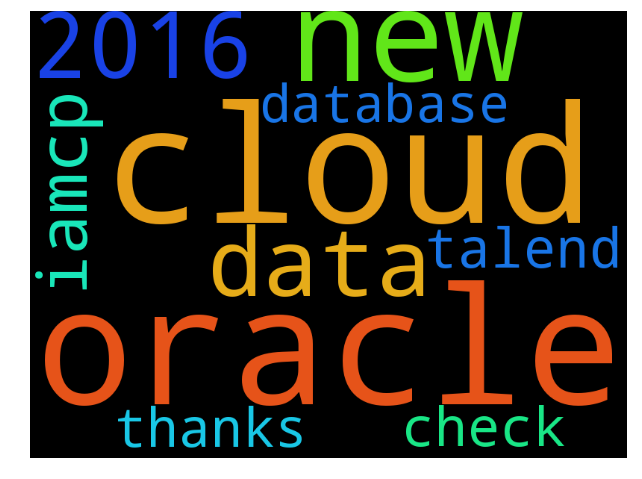

In [9]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)


Topic #0:
93.4: cloud
60.8: oracle
44.2: lukaseder
44.0: not
43.0: it's
41.9: but
40.7: talend
40.6: new
39.0: data
35.0: bigdata
34.1: check
34.0: iamcp
31.6: day
31.5: week
29.5: see
27.4: use
27.3: work
26.7: still
26.5: service
26.5: 5

Topic #1:
114.6: oracle
71.1: 2016
61.9: new
59.8: thanks
44.9: database
39.9: ukoug
35.9: patch
35.3: available
33.8: data
33.5: october
32.6: iamcp
29.3: check
25.9: what's
25.6: join
25.4: microsoft
25.2: 2
24.5: business
23.1: look
23.1: talend
22.6: 10

['93.4: cloud', '60.8: oracle', '44.2: lukaseder', '44.0: not', "43.0: it's", '41.9: but', '40.7: talend', '40.6: new', '39.0: data', '35.0: bigdata', '34.1: check', '34.0: iamcp', '31.6: day', '31.5: week', '29.5: see', '27.4: use', '27.3: work', '26.7: still', '26.5: service', '26.5: 5']
['114.6: oracle', '71.1: 2016', '61.9: new', '59.8: thanks', '44.9: database', '39.9: ukoug', '35.9: patch', '35.3: available', '33.8: data', '33.5: october', '32.6: iamcp', '29.3: check', "25.9: what's", '25.

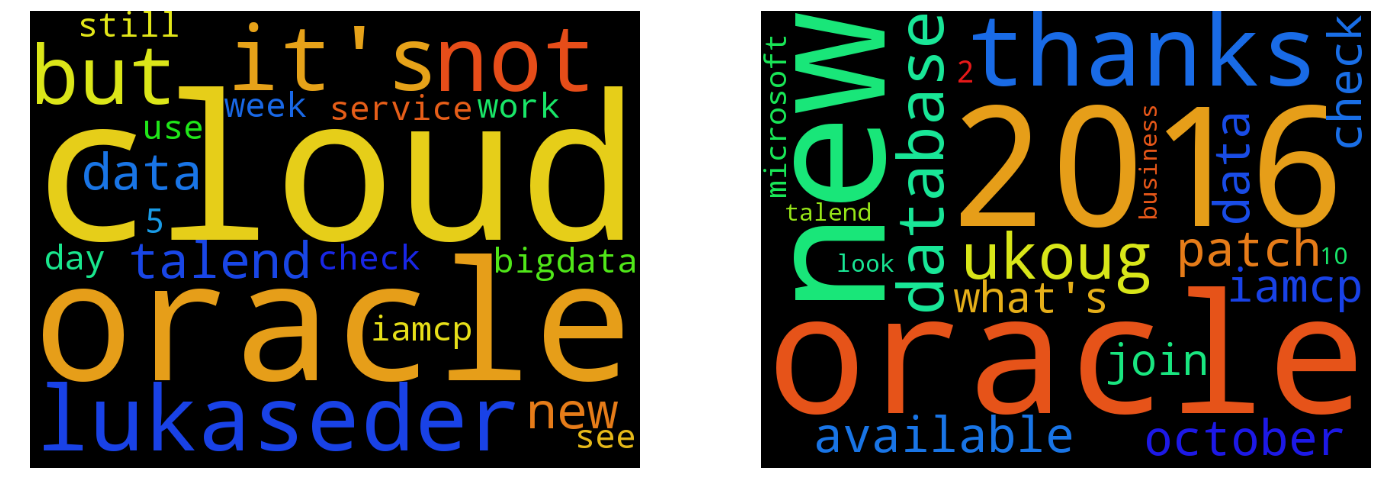

In [10]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

Topic #0:
50.8: not
49.9: cloud
41.8: but
38.3: talend
36.6: day
34.7: data
33.9: oracle
31.5: bigdata
30.5: see
30.0: it's
26.2: lukaseder
25.6: iamcp
23.2: 5
21.9: use
18.9: week
18.3: right
17.0: check
16.6: machinelearning
16.6: spark
16.6: open

Topic #1:
41.5: oracle
38.8: ukoug
37.7: data
32.9: 2016
29.9: like
29.0: 2
25.1: talend
24.7: lukaseder
23.7: community
23.0: look
21.2: patch
20.9: https
20.7: thanks
19.9: hadoop
19.7: no
19.1: bigdata
19.1: rmoff
19.0: big
18.8: available
18.4: really

Topic #2:
101.2: new
100.0: oracle
49.8: cloud
41.4: database
38.5: sfonplsql
36.2: 2016
30.5: thanks
30.5: check
29.8: sql
28.2: great
28.2: what's
27.0: orclapex
26.2: help
24.7: plsql
24.4: find
23.8: iamcp
23.4: join
22.8: work
22.7: programming
22.2: javaooq

['50.8: not', '49.9: cloud', '41.8: but', '38.3: talend', '36.6: day', '34.7: data', '33.9: oracle', '31.5: bigdata', '30.5: see', "30.0: it's", '26.2: lukaseder', '25.6: iamcp', '23.2: 5', '21.9: use', '18.9: week', '18.3: rig

(0.0, 1.0, 0.0, 1.0)

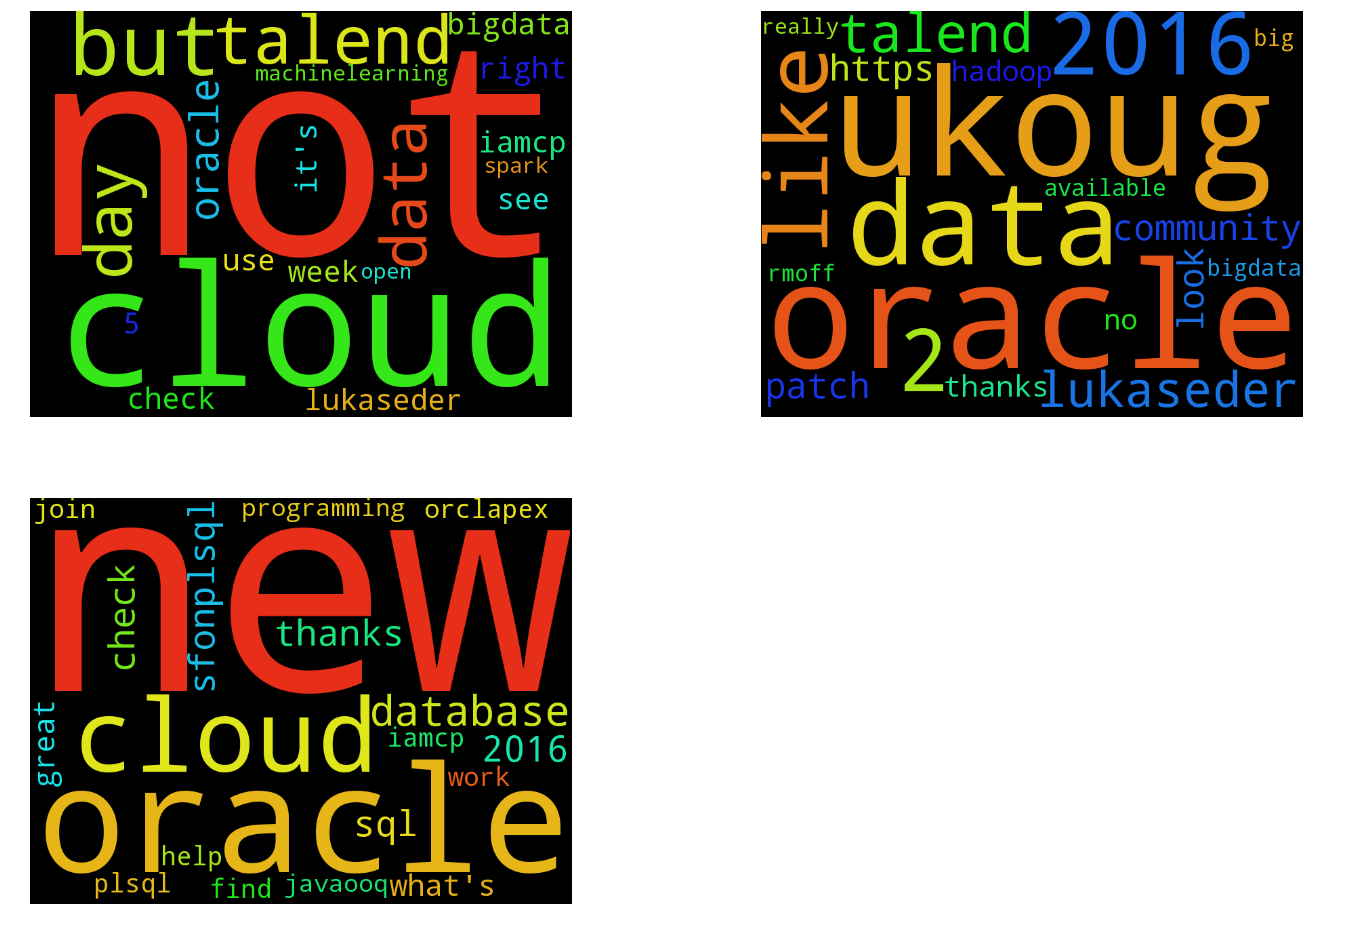

In [11]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

Topic #0:
48.4: not
41.3: talend
30.7: check
30.2: iamcp
29.9: see
29.0: events
27.3: day
24.0: use
23.3: oracle
21.8: but
20.8: it's
19.4: week
16.6: excited
16.4: lots
16.3: latest
16.3: part
16.1: 5
14.7: bigdata
14.7: open
14.0: happening

Topic #1:
66.5: oracle
54.8: 2016
39.9: ukoug
37.8: data
35.7: patch
35.3: available
33.3: thanks
32.9: database
31.9: october
29.2: 2
24.4: no
23.7: check
23.0: look
20.5: what's
20.4: 10
19.9: really
19.6: good
19.0: rmoff
18.5: take
17.1: sessions

Topic #2:
79.0: new
72.5: cloud
58.9: oracle
30.7: sfonplsql
29.4: microsoft
28.9: thanks
27.8: iamcp
24.8: iot
24.4: orclapex
23.1: code
21.3: database
20.3: 12.2
20.2: way
19.0: post
18.8: know
18.5: work
18.4: want
18.1: w
17.8: also
17.8: world

Topic #3:
38.2: lukaseder
34.4: data
26.7: oracle
25.2: cloud
22.9: new
22.7: help
22.6: programming
22.6: hadoop
21.5: talend
21.0: javaooq
20.2: but
19.5: week
19.1: business
18.9: find
18.9: big
18.1: learn
18.0: stay
17.1: team
16.8: jooq
16.7: expla

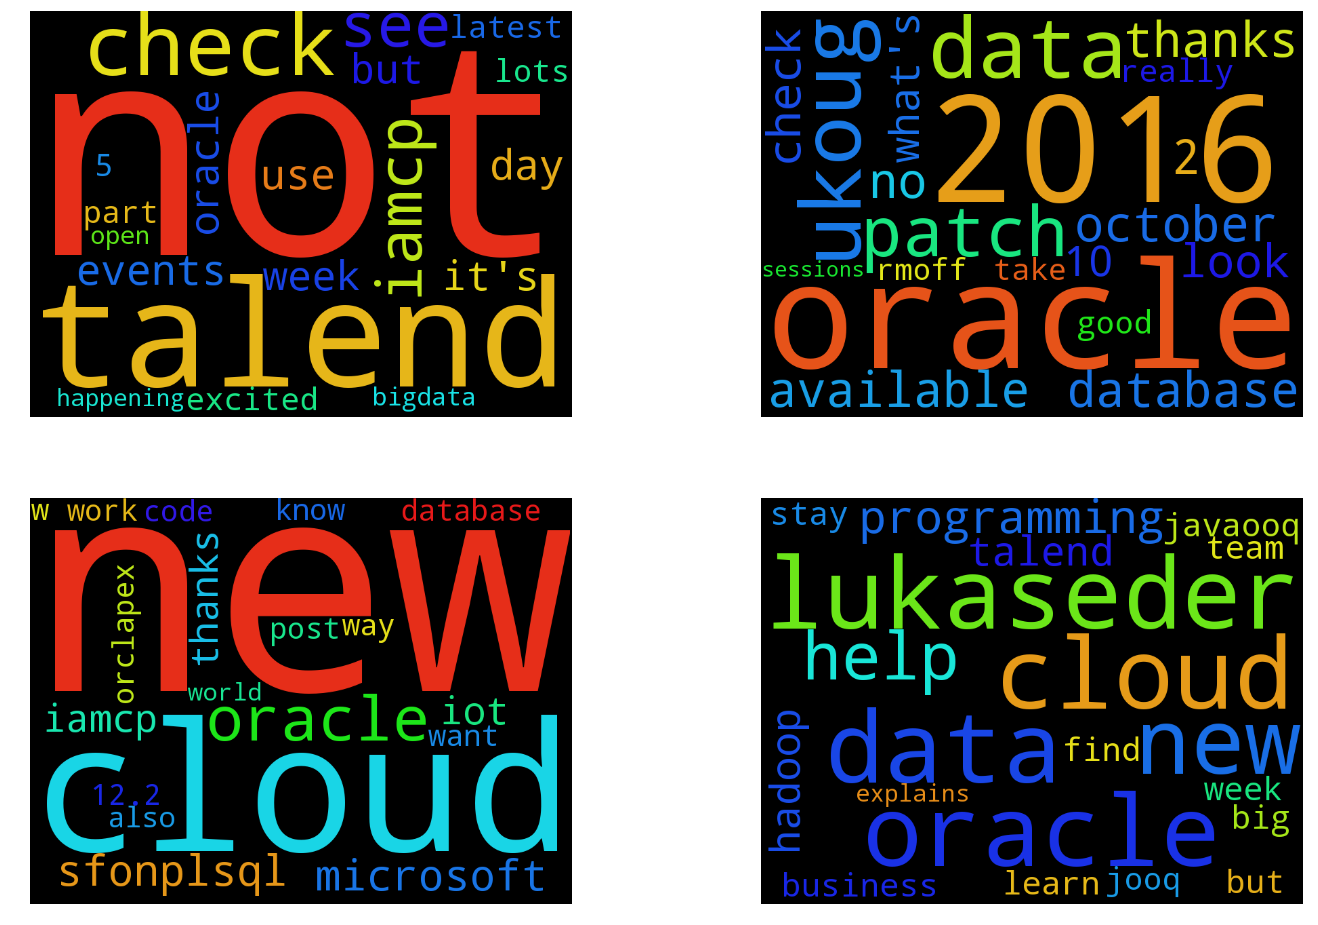

In [12]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

# Tweets in German

In [13]:
tweets_german = pd.read_csv(german_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})
    
tweets_german['text_wo_#'] = tweets_german['text_processed'].apply(lambda x: remove_hash(x))
tweets_german['text_wo_#@'] = tweets_german['text_wo_#'].apply(lambda x: remove_at(x))

X_train = tweets_german['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("german"))
stopwords_nltk
relevant_words = set(['aber', 'nicht', 'nichts', 'ohne', 'nur', 'sehr', 'sollte', 'viel'])

additional_stopwords = set([''])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [15]:
X_train[-10:]

705    NDU_Team Ein Tag bei bauerkirch in 87 Sekunden Treffe die Digitalisierungs-Profis aus Oberforstb...
706    aarnoaukia Kennt jemand einen Info-Studenten der einen Nebenjob sucht Neue Sachen ausprobieren u...
707    INFOGRAZ genau die Einen lösen ihre Probleme mit kriegerischer Gewalt die Harmlosen müssen sich ...
708    aessing bweissman sql_williamd Oh mein Gott vielleicht ezähl ich sonst noch was über PowerBI und...
709                                 aessing wstrasser bweissman sql_williamd die können sogar Ski Fahren 😉
710                aessing bweissman wstrasser sql_williamd ja hier das Beweisfoto https://t.co/goNaPcVOtz
711    UniFAU Nicht vergessen am 27.Oktober findet wieder die Nacht der Unternehmen statt inkl Shuttles...
712    Digitalisierung ist Chefsache und gehört in die Agenda Ausbildung Weiterbildung https://t.co/chC...
713    aessing FrankGeisler bweissman sql_williamd Das ist unser Stichwort FrankGeisler weitere Planung...
714    sawi Digitalisierung ist Chefs